# Feature Engineering and Model Selection - Classification
1. Reading and loading data
2. Pre-processing
For each edf file, we cannot assume the first channel is always the same physical location of electrode. 
1. Set some standard label and order.
Ideally I can use data.frame, however I will first see what format others used. The order can be arbitrary, but I will see what other used first.
2. Read edf file and its montage, 
This can be done using the aforementioned functions from pystream
3. Convert edf reading to standard format.
This can be done using numpy and panda
4. Chop seizure
Comparing the sampling rate, time and annotated time, we extract some chunks of seizure signal.
5. Chop pre-ictal 
Chop from 10 to 20 seconds preceding seizures.
6. Chop background
10 minutes preceding seizures and 10 minutes after seizures. 

## EDA

In [37]:
import sys
sys.path.append('..')
sys.path.append('../seizurecast/')
from seizurecast.data.file_io import * 
import os
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt

In [13]:
# relabeling config
LEN_PRE = 15
LEN_POS = 60
SEC_GAP = 0

In [18]:
train_path = '../../tusz_1_5_2/edf/train/'
tcp_type = '01_tcp_ar'
patient_group = '004'
patient = '00000492'
session = 's003_2003_07_18'
token = '00000492_s003_t001'

In [19]:
edfs = listdir_edfs(train_path+tcp_type, ['token'])
edfs.head()

,path0,path1,path2,path3,path4,path5,path6,path7,path8,token,token_path
0,..,..,tusz_1_5_2,edf,train,01_tcp_ar,104,00010435,s001_2013_06_19,00010435_s001_t000,../../tusz_1_5_2/edf/train/01_tcp_ar/104/00010...
1,..,..,tusz_1_5_2,edf,train,01_tcp_ar,104,00010461,s001_2013_06_21,00010461_s001_t000,../../tusz_1_5_2/edf/train/01_tcp_ar/104/00010...
2,..,..,tusz_1_5_2,edf,train,01_tcp_ar,104,00010450,s001_2013_06_19,00010450_s001_t000,../../tusz_1_5_2/edf/train/01_tcp_ar/104/00010...
3,..,..,tusz_1_5_2,edf,train,01_tcp_ar,104,00010450,s001_2013_06_19,00010450_s001_t001,../../tusz_1_5_2/edf/train/01_tcp_ar/104/00010...
4,..,..,tusz_1_5_2,edf,train,01_tcp_ar,104,00010489,s005_2013_07_10,00010489_s005_t006,../../tusz_1_5_2/edf/train/01_tcp_ar/104/00010...


In [5]:
"""Test preprocess"""
# #TODO: update file_io.py
# from preprocess import preprocess

# def test_preprocess(token_path):
#     # Test
#     f, s, l = read_1_token(token_path)
#     s = preprocess(s, SAMPLING_RATE/np.mean(f))
#     pd.DataFrame(s.transpose(), columns=['ch'+str(i) for i in range(0, len(s))]).plot()
    

# SAMPLING_RATE = 256
# test_preprocess(edfs['token_path'][0])
# # edfs.head()



'Test preprocess'

## Labeling 

In [25]:
def load_50_patients():
    """Load 50 datasets ~2 MIN"""
    from seizurecast.data.make_dataset import make_dataset

    # relabeling config
    LEN_PRE = 300  # 5 minutes pre
    LEN_POS = 600
    SEC_GAP = 600  # 10 minutes gap
    SAMPLING_RATE = 256

    token_paths = edfs.sample(50, random_state=0)['token_path'].to_numpy()
    dataset, labels = make_dataset(token_paths, 
                                             len_pre=LEN_PRE, len_post=LEN_POS, sec_gap=SEC_GAP, fsamp=SAMPLING_RATE)
    # dataset, labels = make_dataset(get_1_session_tokens()[0:5])
    np.shape(dataset), np.shape(labels)

    with open('../tmp/ds10min.pkl', 'wb') as fp:
        pickle.dump((dataset, labels), fp)

In [26]:
"""Load pre-cached dataset"""
import pickle
with open('../tmp/ds.pkl', 'rb') as fp:
    dataset, labels = pickle.load(fp)


## Balance Data

In [28]:
from seizurecast.features.dataset_funcs import balance_ds

np.random.seed(100)
dataset, labels = balance_ds(dataset, labels)
dataset.shape, labels.shape

((3865, 8, 256), (3865,))

## Visualize sample EEG traces

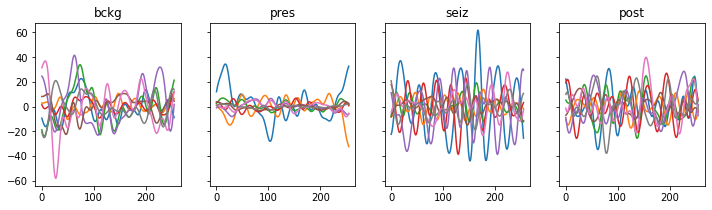

In [30]:
def peek_time_series(dataset, labels):
    find_label = lambda l, v: [i for i,x in enumerate(l) if x==v]

    _, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,3), sharey=True)

    ishows = [find_label(labels, lbl)[1]-1 for lbl in [LABEL_BKG, LABEL_PRE, LABEL_SEZ, LABEL_POS]]

    for i, ax in enumerate(axes.flat):
        pd.DataFrame(np.transpose(dataset[ishows[i]])).plot(ax=ax, legend=False)
        ax.set_title(labels[ishows[i]])

peek_time_series(dataset, labels)

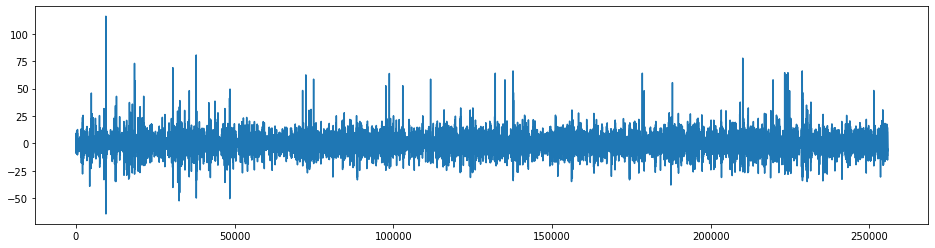

In [35]:
ds = np.concatenate(dataset[1:1000], 1)
plt.figure(figsize=[16, 4])
plt.plot(ds.T[::-1,1])

# pd.DataFrame(ds.T[::-1,1]).rolling(1000).mean().plot()


# Features

In [39]:
from features.dataset_funcs import bin_power

dataset_power = bin_power(dataset, fsamp = 256)
np.shape(dataset_power)   

(3865, 8, 44)

#### Plot: power spec

In [13]:
locate = lambda listOfElems, elem: [ i for i in range(len(listOfElems)) if listOfElems[i] == elem ]
"""Return all the indexed of an element in a list"""

def explore2D(ds, labels, title=''):
    """
    ds: nepochs x nchannels x nsamples
    """
    arranges = (LABEL_BKG, LABEL_PRE)
    nrows, ncols = len(arranges), len(ds[0])
    
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
    for i, epoch in enumerate(ds):
        ir = arranges.index(labels[i])
        for ic, channel in enumerate(epoch):
            axes[ir][ic].plot(channel)

def peek_powerspec(dataset_power, labels): 
    ds_pwd = np.array(dataset_power)

#     ds_bkg, ds_pre, ds_sez, ds_pos = [], [], [], []
    ds_bkg = ds_pwd[locate(labels, LABEL_BKG),:,:]
    ds_pre = ds_pwd[locate(labels, LABEL_PRE),:,:]

    np.random.seed(0)
    rnd_indices = np.random.choice(np.shape(ds_bkg)[0], size=100)
    rnd_indices2 = np.random.choice(np.shape(ds_pre)[0], size=100)

    explore2D(np.concatenate((ds_bkg[rnd_indices], ds_pre[rnd_indices2])), labels=[LABEL_BKG]*100+[LABEL_PRE]*100)

# peek_powerspec(dataset_power, labels)

Looks like we can use the powers of 22 channels to differentiate PRE vs BKG. 
We can compute the AUC to represent the average power. Or, compute the average frequency.

### compute the power of each channel.


In [41]:
from features.dataset_funcs import bin_power_freq
from utils import dataset2Xy


def calculate_power(dataset_power, labels, id_filtered):
    ds_pwd = bin_power_freq(dataset_power)
    X, y = dataset2Xy(ds_pwd, labels)
    return X[id_filtered, :], y[id_filtered]


id_bkg_pre = [any([yi == lbl for lbl in [LABEL_BKG, LABEL_PRE]]) for yi in labels]
# id_pre = [any([yi == lbl for lbl in [LABEL_PRE]]) for yi in labels]
# id_bkg = [any([yi == lbl for lbl in [LABEL_BKG]]) for yi in labels]
X, y = calculate_power(dataset_power, labels, id_bkg_pre)

#### profiling

In [42]:
from pandas_profiling import ProfileReport
profile = ProfileReport(pd.DataFrame(X).assign(labels=y), minimal=False, explorative=True)

# profile.to_notebook_iframe()

Outliers are there and need to remove

# Model Selection

In [43]:
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression


In [44]:
# Binarize the label
y_b = preprocessing.label_binarize(y, classes=[LABEL_BKG, LABEL_PRE])
y_b = np.reshape(y_b, (len(y_b),))

# Train test split
train_X, test_X, train_y, test_y = train_test_split(X, y_b,
    test_size=0.2,
    random_state=41)

np.shape(train_X), test_X.shape, train_y.shape, test_y.shape

((1236, 16), (310, 16), (1236,), (310,))

## Cross validation

In [45]:
clf = {}

# Linear Model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf['lda'] = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
cross_val_score(clf['lda'], train_X, train_y, cv=5)

array([0.5       , 0.63157895, 0.53441296, 0.5465587 , 0.55465587])

In [46]:
clf['lg'] = LogisticRegression(random_state=0, max_iter=2000)
cross_val_score(clf['lg'], train_X, train_y, cv=5)

array([0.56451613, 0.65182186, 0.62348178, 0.63562753, 0.63157895])

In [47]:
from sklearn.ensemble import RandomForestClassifier
clf['rf'] = RandomForestClassifier(n_estimators=40, max_depth=None,
    min_samples_split=3, random_state=0)
cross_val_score(clf['rf'], train_X, train_y, cv=5)

array([0.77419355, 0.77327935, 0.7611336 , 0.77327935, 0.75708502])

In [48]:
from sklearn.ensemble import AdaBoostClassifier
clf['adb'] = AdaBoostClassifier(n_estimators=100, random_state=0)
cross_val_score(clf['adb'], train_X, train_y, cv=5)

array([0.65725806, 0.66396761, 0.66801619, 0.67611336, 0.68016194])

In [49]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler  # doctest: +SKIP
scaler = StandardScaler()  # doctest: +SKIP
# Don't cheat - fit only on training data
scaler.fit(train_X)  # doctest: +SKIP
train_X_s = scaler.transform(train_X)  # doctest: +SKIP
# apply same transformation to test data
test_X_s = scaler.transform(test_X)  # doctest: +SKIP

clf['mlp'] = MLPClassifier(solver='lbfgs', alpha=1e0, hidden_layer_sizes=(10, 5), max_iter=10000, random_state=1)
cross_val_score(clf['mlp'], train_X_s, train_y, cv=5)

array([0.68951613, 0.74089069, 0.69635628, 0.68421053, 0.74493927])

In [37]:
# # Export the clf for evaluation
# with open('tmp/model.pkl', 'wb') as fp:
#     pickle.dump((clf, X, y), fp)

## save a couple txt files for demo

In [6]:
import pickle
with open('../models/model.pkl', 'rb') as fp:
    clf = pickle.load(fp)

# load dataset
import pickle
with open('../tmp/ds10min.pkl', 'rb') as fp:
    dataset, labels = pickle.load(fp)
np.shape(dataset)

NameError: name 'np' is not defined

In [22]:
import numpy as np
import sys
sys.path.append('..')
from seizurecast.models.par import LABEL_PRE, LABEL_BKG
ds, y = dataset, labels
id_pre = np.array([yi for yi in range(0, len(y)) if any([y[yi] == lbl for lbl in [LABEL_PRE]])])
id_bkg = np.array([yi for yi in range(0, len(y)) if any([y[yi] == lbl for lbl in [LABEL_BKG]])])
eval_X_pre = [ds[i] for i in np.random.choice(id_pre, size=100)]
eval_X_bkg = [ds[i] for i in np.random.choice(id_bkg, size=100)]
ds = []
for i in range(0, len(eval_X_pre)+len(eval_X_bkg)-2):
    if i//50%2 == 0:
        ds.extend(np.transpose(eval_X_bkg.pop()))
    else:
        ds.extend(np.transpose(eval_X_pre.pop()))
   

(-1, 8)

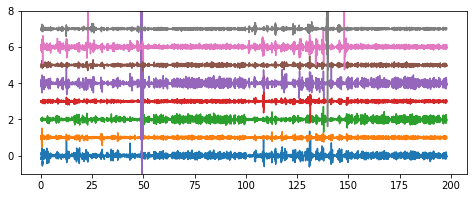

In [34]:
datplot = np.transpose(ds)
x = np.arange(0, datplot.shape[1]) / 256
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 3))
for i in range(datplot.shape[0]):
    yi = datplot[i]/(np.max(datplot[i])-np.min(datplot[i]))
    yi = datplot[i] / 150
    plt.plot(x, yi+i)
plt.ylim([-1, 8])

In [14]:
         
with open('../data/processed/svdemo-5bkg-5pre-5bkg-5pre.txt', 'wb') as fp:
    # Must be saved as nchannel x nsample
    np.savetxt(fp, np.transpose(ds), delimiter=',')

In [41]:
# np.shape(X), np.shape(y)

((1572427, 16), (1572427,))

In [74]:
# id_pre = np.array([yi for yi in range(0, len(y)) if any([y[yi] == lbl for lbl in [LABEL_PRE]])])
# id_bkg = np.array([yi for yi in range(0, len(y)) if any([y[yi] == lbl for lbl in [LABEL_BKG]])])


# eval_X_pre = [X[i] for i in np.random.choice(id_pre, size=100)]
# eval_X_bkg = [X[i] for i in np.random.choice(id_bkg, size=100)]

# clf.predict(np.concatenate([eval_X_pre, eval_X_bkg]))

# ds = []
# with open('./data/svdemo-3bkg-3pre-3bkg-3pre.txt', 'wb') as fp:
#     for i in range(0, len(eval_X_pre)+len(eval_X_bkg)-2):
#         if i//3%2 == 0:
#             ds.append(eval_X_bkg.pop())
#         else:
#             ds.append(eval_X_pre.pop())
#     np.savetxt(fp, ds, delimiter=',')
# clf.predict(ds)


array([0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1])

### Test if the saved raw data can be used to evaluate

In [87]:
import dataset_funcs
x = dataset_funcs.bin_power_freq([np.loadtxt('./data/svdemo-3bkg-3pre-3bkg-3pre.txt', delimiter=',')], 256)
clf.predict(x)

AttributeError: module 'dataset_funcs' has no attribute 'bin_power_freq'